# Pelatihan, Tuning, dan Evaluasi Model

Notebook ini adalah inti dari proyek klasifikasi gambar. Di sini, kita akan melalui seluruh alur kerja machine learning:
1.  **Memuat dan Membagi Data**: Memuat dataset dan membaginya menjadi set pelatihan dan pengujian.
2.  **Augmentasi Data**: Menerapkan augmentasi pada set pelatihan untuk meningkatkan generalisasi model.
3.  **Definisi Pipeline Terintegrasi**: Membuat kelas `IntegratedClassifier` yang menggabungkan prapemrosesan, ekstraksi fitur, dan klasifikasi SVM dalam satu pipeline yang koheren.
4.  **Tuning Hyperparameter**: Menggunakan `GridSearchCV` untuk menemukan kombinasi parameter terbaik untuk model SVM.
5.  **Pelatihan dan Penyimpanan**: Melatih model terbaik pada seluruh data pelatihan (termasuk data augmentasi) dan menyimpannya ke disk.
6.  **Evaluasi Model**: Mengevaluasi kinerja model terbaik pada set pengujian yang tidak terlihat, menggunakan berbagai metrik dan visualisasi.

In [1]:
import os
import sys
import cv2
import joblib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from scipy.stats import skew

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from src.configs.config import (
    DATA_RAW_PATH, RESULTS_PATH, SAVED_MODEL_PATH, CLASSES, IMAGE_SIZE,
    HOG_ORIENTATIONS, HOG_PIXELS_PER_CELL, HOG_CELLS_PER_BLOCK, 
    TEST_SIZE, RANDOM_STATE
)
from src.utils.logger import logger
from src.utils.dataset_loader import load_images_from_folder
from src.utils.metrics import evaluate_model, plot_confusion_matrix
from src.utils.roc_curve import plot_roc_curve
from src.utils.precision_recall import plot_precision_recall_curve
from src.utils.prediction_examples import plot_prediction_examples

## Fungsi Pembantu (Helper Functions)

Kumpulan fungsi untuk augmentasi gambar, prapemrosesan, dan ekstraksi fitur. Fungsi-fungsi ini akan digunakan di dalam pipeline `IntegratedClassifier`.

In [2]:
def augment_image(image):
    """Menerapkan beberapa teknik augmentasi pada sebuah gambar."""
    augmented_images = [image] # Mulai dengan gambar asli
    # Augmentasi 1: Flip Horizontal
    augmented_images.append(cv2.flip(image, 1))
    
    # Augmentasi 2: Perubahan Kecerahan (dinonaktifkan)
    # augmented_images.append(np.clip(image * 1.2, 0, 255).astype(np.uint8))
    # augmented_images.append(np.clip(image * 0.8, 0, 255).astype(np.uint8))
    
    # Augmentasi 3: Rotasi Acak
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    angle = random.uniform(-15, 15)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    augmented_images.append(cv2.warpAffine(image, M, (w, h)))
    
    # Augmentasi 4: Sharpening
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpened = cv2.filter2D(image, -1, kernel)
    augmented_images.append(sharpened)
    
    # Augmentasi lainnya (dinonaktifkan)
    smoothed = cv2.GaussianBlur(image, (5, 5), 0)
    # augmented_images.append(smoothed)
    kernel_morph = np.ones((3,3), np.uint8)
    min_filtered = cv2.erode(image, kernel_morph, iterations=1)
    # augmented_images.append(min_filtered)
    max_filtered = cv2.dilate(image, kernel_morph, iterations=1)
    # augmented_images.append(max_filtered)
    
    return augmented_images

def resize_image(image):
    """Mengubah ukuran gambar ke ukuran standar."""
    return cv2.resize(image, IMAGE_SIZE, interpolation=cv2.INTER_AREA)

def to_grayscale(image):
    """Mengonversi gambar BGR ke grayscale."""
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def normalize_image(image):
    """Menormalisasi nilai piksel gambar ke rentang [0.0, 1.0]."""
    return image.astype('float32') / 255.0

def preprocess_image_for_feature_extraction(image):
    """Pipeline prapemrosesan lengkap untuk satu gambar."""
    resized_color_uint8 = resize_image(image)
    gray_image = to_grayscale(resized_color_uint8)
    normalized_gray = normalize_image(gray_image)
    normalized_color = normalize_image(resized_color_uint8)
    return normalized_gray, normalized_color

def extract_hog_features(gray_image):
    """Mengekstrak fitur HOG."""
    return hog(gray_image, orientations=HOG_ORIENTATIONS, pixels_per_cell=HOG_PIXELS_PER_CELL,
               cells_per_block=HOG_CELLS_PER_BLOCK, block_norm='L2-Hys', visualize=False, transform_sqrt=True)

def extract_color_histogram(color_image):
    """Mengekstrak fitur histogram warna HSV."""
    hsv_image = cv2.cvtColor((color_image * 255).astype(np.uint8), cv2.COLOR_BGR2HSV)
    hist_h = cv2.calcHist([hsv_image], [0], None, [180], [0, 180])
    hist_s = cv2.calcHist([hsv_image], [1], None, [32], [0, 256])
    hist_v = cv2.calcHist([hsv_image], [2], None, [32], [0, 256])
    cv2.normalize(hist_h, hist_h)
    cv2.normalize(hist_s, hist_s)
    cv2.normalize(hist_v, hist_v)
    return np.concatenate((hist_h, hist_s, hist_v)).flatten()

def extract_lbp_features(gray_image):
    """Mengekstrak fitur LBP."""
    gray_image_uint8 = (gray_image * 255).astype(np.uint8)
    radius, n_points = 8, 24
    lbp = local_binary_pattern(gray_image_uint8, n_points, radius, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

def extract_color_moments(color_image):
    """Mengekstrak fitur color moments Lab dengan penanganan standar deviasi nol."""
    lab_image = cv2.cvtColor((color_image * 255).astype(np.uint8), cv2.COLOR_BGR2Lab)
    l, a, b = cv2.split(lab_image)
    channels = [l, a, b]
    features = []
    for channel in channels:
        mean = np.mean(channel)
        std = np.std(channel)
        if std > 1e-6:
            skewness = skew(channel.flatten())
        else:
            skewness = 0.0 # Jika std nol, skewness juga nol
        features.extend([mean, std, skewness])
    return np.array(features)

def extract_glcm_features(gray_image):
    """Mengekstrak fitur tekstur GLCM."""
    gray_image_uint8 = (gray_image * 255).astype(np.uint8)
    distances = [1, 3, 5]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(gray_image_uint8, distances=distances, angles=angles, symmetric=True, normed=True)
    
    features = []
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    for prop in props:
        features.append(graycoprops(glcm, prop).ravel())
        
    return np.concatenate(features)

def extract_gabor_features(gray_image):
    """Mengekstrak fitur tekstur Gabor."""
    img = (gray_image * 255).astype(np.uint8)
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 4):
        for lambd in np.arange(np.pi / 4, np.pi, np.pi / 4):
            for sigma in (1, 3):
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, 0.5, 0, ktype=cv2.CV_32F)
                filters.append(kernel)

    features = []
    for kernel in filters:
        filtered_img = cv2.filter2D(img, cv2.CV_8UC3, kernel)
        features.append(filtered_img.mean())
        features.append(filtered_img.std())
    
    return np.array(features)

def extract_sobel_features(gray_image):
    """Mengekstrak fitur tepi Sobel."""
    img_uint8 = (gray_image * 255).astype(np.uint8)
    sobelx = cv2.Sobel(img_uint8, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img_uint8, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    (hist, _) = np.histogram(magnitude.ravel(), bins=32, range=(0, 256))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

def extract_features(gray_image, color_image):
    """Menggabungkan semua fitur menjadi satu vektor tunggal."""
    hog_features = extract_hog_features(gray_image)
    color_hist_features = extract_color_histogram(color_image)
    lbp_features = extract_lbp_features(gray_image)
    gabor_features = extract_gabor_features(gray_image)
    sobel_features = extract_sobel_features(gray_image)
    glcm_features = extract_glcm_features(gray_image)
    color_moments = extract_color_moments(color_image)
    all_features = np.hstack([hog_features, color_hist_features, lbp_features, gabor_features, sobel_features, glcm_features, color_moments])
    if np.isnan(all_features).any():
        logger.warning("Peringatan: Nilai NaN terdeteksi dalam vektor fitur!")
    return all_features

## Definisi Class `IntegratedClassifier`

Class ini mewarisi dari `BaseEstimator` dan `ClassifierMixin` agar kompatibel dengan alat-alat scikit-learn seperti `GridSearchCV`.

-   `__init__()`: Menginisialisasi pipeline yang terdiri dari `StandardScaler`, `PCA`, dan `SVC`.
-   `_preprocess_and_extract()`: Metode privat yang mengambil gambar mentah dan menerapkan seluruh alur prapemrosesan dan ekstraksi fitur.
-   `fit()`: Menerima gambar mentah, memanggil `_preprocess_and_extract`, lalu melatih pipeline SVM.
-   `predict()` & `predict_proba()`: Menerima gambar mentah, memanggil `_preprocess_and_extract`, dan mengembalikan prediksi atau probabilitas.

In [3]:
class IntegratedClassifier(BaseEstimator, ClassifierMixin):
    """Pipeline terintegrasi yang menerima gambar mentah.
    
    Menggabungkan semua langkah dari prapemrosesan, ekstraksi fitur,
    penskalaan, reduksi dimensi (PCA), hingga klasifikasi SVM. Dibuat agar
    kompatibel dengan `GridSearchCV` dari scikit-learn.
    """
    def __init__(self, C=1.0, gamma='scale'):
        """Inisialisasi hyperparameter dan pipeline model."""
        self.C = C
        self.gamma = gamma
        self.pipeline = make_pipeline(
            StandardScaler(),
            PCA(n_components=0.95, random_state=RANDOM_STATE),
            SVC(kernel='rbf', C=self.C, gamma=self.gamma, probability=True, 
                random_state=RANDOM_STATE, class_weight='balanced')
        )

    def _preprocess_and_extract(self, X_raw):
        """Metode internal untuk memproses dan mengekstrak fitur dari gambar mentah."""
        feature_list = []
        # Menampilkan progress bar dengan tqdm
        for image in tqdm(X_raw, desc="Feature Extraction"):
            gray_img, color_img = preprocess_image_for_feature_extraction(image)
            features = extract_features(gray_img, color_img)
            feature_list.append(features)
        return np.array(feature_list)

    def fit(self, X_raw, y):
        """Melatih model pada data gambar mentah (X_raw) dan label (y)."""
        X_features = self._preprocess_and_extract(X_raw)
        logger.info(f"Melatih pipeline pada matriks fitur berbentuk: {X_features.shape}")
        if np.isnan(X_features).any():
            raise ValueError("Masih ada NaN di data fitur sebelum training!")
        self.pipeline.fit(X_features, y)
        return self

    def predict(self, X_raw):
        """Memprediksi kelas untuk data gambar mentah (X_raw)."""
        X_features = self._preprocess_and_extract(X_raw)
        return self.pipeline.predict(X_features)

    def predict_proba(self, X_raw):
        """Memprediksi probabilitas kelas untuk data gambar mentah (X_raw)."""
        X_features = self._preprocess_and_extract(X_raw)
        return self.pipeline.predict_proba(X_features)

In [ ]:
# Langkah 1: Memuat data asli
images_orig, labels_orig, _ = load_images_from_folder(DATA_RAW_PATH)
X_orig = np.array(images_orig, dtype=object)
y_orig = np.array(labels_orig)

# Langkah 2: Membagi data menjadi set pelatihan dan pengujian (stratified)
X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X_orig, y_orig, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_orig
)
logger.info(f"Data asli dibagi: {len(X_train_orig)} train, {len(X_test)} test.")

# Langkah 3: Menerapkan augmentasi hanya pada data pelatihan
X_train_augmented = []
y_train_augmented = []
logger.info("Menerapkan augmentasi pada data latih...")
for img, label in tqdm(zip(X_train_orig, y_train_orig), total=len(X_train_orig), desc="Augmenting Training Data"):
    augmented_images = augment_image(img)
    for aug_img in augmented_images:
        X_train_augmented.append(aug_img)
        y_train_augmented.append(label)

# Konversi data yang sudah di-augmentasi menjadi array NumPy
X_train = np.array(X_train_augmented, dtype=object)
y_train = np.array(y_train_augmented)
logger.info(f"Ukuran data latih setelah augmentasi: {len(X_train)}")

# Membuat subset KECIL untuk proses tuning hyperparameter yang CEPAT
n_samples_for_tuning = min(len(X_train), 1500)
logger.info(f"Membuat subset untuk tuning cepat dengan {n_samples_for_tuning} sampel.")
X_train_subset, y_train_subset = resample(
    X_train, y_train,
    n_samples=n_samples_for_tuning,
    random_state=RANDOM_STATE,
    stratify=y_train
)

# Langkah 4: Menentukan grid hyperparameter untuk GridSearchCV
param_grid = {
    'C': [0.005, 0.01, 0.02],
    'gamma': [0.0001, 0.00025, 0.0005]
}

# Inisialisasi model terintegrasi
integrated_model = IntegratedClassifier()

logger.info("="*50)
logger.info("MEMULAI TUNING HYPERPARAMETER")
logger.info(f"Parameter Grid yang Diuji: {param_grid}")
logger.info("="*50)

# Langkah 5: Menjalankan GridSearchCV pada SUBSET data untuk efisiensi
grid_search = GridSearchCV(integrated_model, param_grid, cv=3, verbose=2, n_jobs=1)
grid_search.fit(X_train_subset, y_train_subset)

# Menampilkan hasil tuning terbaik
logger.info("\nTuning selesai.")
logger.info(f"Parameter terbaik ditemukan: {grid_search.best_params_}")
logger.info(f"Skor cross-validation terbaik (pada subset): {grid_search.best_score_:.4f}")

# Setelah menemukan parameter terbaik, latih ulang model pada SELURUH data latih
# untuk mendapatkan performa yang paling optimal.
logger.info("\nMelatih ulang model terbaik pada seluruh data latih...")
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train) # Latih ulang pada X_train dan y_train yang lengkap

# Langkah 6: Menyimpan model terbaik yang sudah dilatih ulang ke disk
integrated_model_path = SAVED_MODEL_PATH
os.makedirs(os.path.dirname(integrated_model_path), exist_ok=True)
joblib.dump(best_model, integrated_model_path)
logger.info(f"Model berhasil disimpan di {integrated_model_path}")

# Langkah 7: Mengevaluasi model terbaik pada data uji
logger.info("Mengevaluasi model pada data uji...")
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

# Membuat dan menyimpan laporan, serta plot evaluasi
evaluate_model(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(y_test, y_pred_proba)
plot_precision_recall_curve(y_test, y_pred_proba)
plot_prediction_examples(X_test, y_test, y_pred)


2025-10-13 02:48:53,497 - INFO - dataset_loader - Memuat gambar dari 'd:\program\python-project\svm-models\build\data\raw'...
Loading Berkabut: 100%|██████████| 300/300 [00:01<00:00, 257.86it/s]
2025-10-13 02:48:57,898 - INFO - dataset_loader - Total gambar yang berhasil dimuat: 1200
2025-10-13 02:48:57,903 - INFO - 3342050111 - Data asli dibagi: 960 train, 240 test.
2025-10-13 02:48:57,904 - INFO - 3342050111 - Menerapkan augmentasi pada data latih...
Augmenting Training Data: 100%|██████████| 960/960 [00:08<00:00, 108.42it/s]
2025-10-13 02:49:06,786 - INFO - 3342050111 - Ukuran data latih setelah augmentasi: 3840
2025-10-13 02:49:06,797 - INFO - 3342050111 - Membuat subset untuk tuning cepat dengan 1500 sampel.
2025-10-13 02:49:06,879 - INFO - 3342050111 - ==================================================
2025-10-13 02:49:06,879 - INFO - 3342050111 - MEMULAI TUNING HYPERPARAMETER
2025-10-13 02:49:06,879 - INFO - 3342050111 - Parameter Grid yang Diuji: {'C': [0.01, 0.025, 0.05, 0.1],

Fitting 3 folds for each of 12 candidates, totalling 36 fits


Feature Extraction: 100%|██████████| 1000/1000 [01:35<00:00, 10.44it/s]
2025-10-13 02:50:42,770 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.10it/s]


[CV] END ...............................C=0.01, gamma=0.0005; total time= 2.3min


Feature Extraction: 100%|██████████| 1000/1000 [01:21<00:00, 12.20it/s]
2025-10-13 02:52:48,958 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:42<00:00, 11.83it/s]


[CV] END ...............................C=0.01, gamma=0.0005; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:24<00:00, 11.88it/s]
2025-10-13 02:54:58,227 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.05it/s]


[CV] END ...............................C=0.01, gamma=0.0005; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:22<00:00, 12.06it/s]
2025-10-13 02:57:05,694 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.04it/s]


[CV] END ................................C=0.01, gamma=0.001; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:23<00:00, 12.04it/s]
2025-10-13 02:59:13,246 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.10it/s]


[CV] END ................................C=0.01, gamma=0.001; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:23<00:00, 12.02it/s]
2025-10-13 03:01:20,752 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.11it/s]


[CV] END ................................C=0.01, gamma=0.001; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:23<00:00, 12.04it/s]
2025-10-13 03:03:28,105 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.10it/s]


[CV] END ...............................C=0.01, gamma=0.0015; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:23<00:00, 12.01it/s]
2025-10-13 03:05:35,583 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.14it/s]


[CV] END ...............................C=0.01, gamma=0.0015; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:23<00:00, 12.01it/s]
2025-10-13 03:07:42,915 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.00it/s]


[CV] END ...............................C=0.01, gamma=0.0015; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:23<00:00, 12.03it/s]
2025-10-13 03:09:50,653 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.07it/s]


[CV] END ..............................C=0.025, gamma=0.0005; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:23<00:00, 11.95it/s]
2025-10-13 03:11:58,656 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.02it/s]


[CV] END ..............................C=0.025, gamma=0.0005; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:23<00:00, 12.03it/s]
2025-10-13 03:14:06,309 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.13it/s]


[CV] END ..............................C=0.025, gamma=0.0005; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:23<00:00, 12.00it/s]
2025-10-13 03:16:13,847 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.06it/s]


[CV] END ...............................C=0.025, gamma=0.001; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:21<00:00, 12.23it/s]
2025-10-13 03:18:19,918 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:40<00:00, 12.32it/s]


[CV] END ...............................C=0.025, gamma=0.001; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:21<00:00, 12.25it/s]
2025-10-13 03:20:24,921 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 11.99it/s]


[CV] END ...............................C=0.025, gamma=0.001; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:23<00:00, 12.01it/s]
2025-10-13 03:22:32,760 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.01it/s]


[CV] END ..............................C=0.025, gamma=0.0015; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:24<00:00, 11.84it/s]
2025-10-13 03:24:41,760 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.09it/s]


[CV] END ..............................C=0.025, gamma=0.0015; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:23<00:00, 12.01it/s]
2025-10-13 03:26:49,396 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.17it/s]


[CV] END ..............................C=0.025, gamma=0.0015; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:22<00:00, 12.08it/s]
2025-10-13 03:28:56,364 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.11it/s]


[CV] END ...............................C=0.05, gamma=0.0005; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:22<00:00, 12.10it/s]
2025-10-13 03:31:03,218 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 11.93it/s]


[CV] END ...............................C=0.05, gamma=0.0005; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:22<00:00, 12.08it/s]
2025-10-13 03:33:10,806 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.11it/s]


[CV] END ...............................C=0.05, gamma=0.0005; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:22<00:00, 12.06it/s]
2025-10-13 03:35:17,958 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.12it/s]


[CV] END ................................C=0.05, gamma=0.001; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:23<00:00, 12.04it/s]
2025-10-13 03:37:25,161 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.04it/s]


[CV] END ................................C=0.05, gamma=0.001; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:23<00:00, 12.00it/s]
2025-10-13 03:39:32,952 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.07it/s]


[CV] END ................................C=0.05, gamma=0.001; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:23<00:00, 12.01it/s]
2025-10-13 03:41:40,535 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.02it/s]


[CV] END ...............................C=0.05, gamma=0.0015; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:23<00:00, 11.98it/s]
2025-10-13 03:43:48,557 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.10it/s]


[CV] END ...............................C=0.05, gamma=0.0015; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:22<00:00, 12.06it/s]
2025-10-13 03:45:55,662 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.14it/s]


[CV] END ...............................C=0.05, gamma=0.0015; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:21<00:00, 12.21it/s]
2025-10-13 03:48:01,743 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:40<00:00, 12.30it/s]


[CV] END ................................C=0.1, gamma=0.0005; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:22<00:00, 12.18it/s]
2025-10-13 03:50:07,216 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:40<00:00, 12.26it/s]


[CV] END ................................C=0.1, gamma=0.0005; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:23<00:00, 12.00it/s]
2025-10-13 03:52:14,072 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.05it/s]


[CV] END ................................C=0.1, gamma=0.0005; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:23<00:00, 12.03it/s]
2025-10-13 03:54:21,664 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.04it/s]


[CV] END .................................C=0.1, gamma=0.001; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:23<00:00, 11.98it/s]
2025-10-13 03:56:29,479 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.11it/s]


[CV] END .................................C=0.1, gamma=0.001; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:23<00:00, 12.01it/s]
2025-10-13 03:58:36,847 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.10it/s]


[CV] END .................................C=0.1, gamma=0.001; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:23<00:00, 12.02it/s]
2025-10-13 04:00:44,254 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.08it/s]


[CV] END ................................C=0.1, gamma=0.0015; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:23<00:00, 12.03it/s]
2025-10-13 04:02:51,654 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 11.99it/s]


[CV] END ................................C=0.1, gamma=0.0015; total time= 2.1min


Feature Extraction: 100%|██████████| 1000/1000 [01:23<00:00, 12.04it/s]
2025-10-13 04:04:59,331 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1000, 8531)
Feature Extraction: 100%|██████████| 500/500 [00:41<00:00, 12.12it/s]


[CV] END ................................C=0.1, gamma=0.0015; total time= 2.1min


Feature Extraction: 100%|██████████| 1500/1500 [02:05<00:00, 11.92it/s]
2025-10-13 04:07:49,284 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (1500, 8531)
2025-10-13 04:07:55,002 - INFO - 3342050111 - 
Tuning selesai.
2025-10-13 04:07:55,006 - INFO - 3342050111 - Parameter terbaik ditemukan: {'C': 0.01, 'gamma': 0.0005}
2025-10-13 04:07:55,006 - INFO - 3342050111 - Skor cross-validation terbaik (pada subset): 0.8327
2025-10-13 04:07:55,006 - INFO - 3342050111 - 
Melatih ulang model terbaik pada seluruh data latih...
Feature Extraction: 100%|██████████| 3840/3840 [06:30<00:00,  9.84it/s]
2025-10-13 04:14:25,530 - INFO - 2503465526 - Melatih pipeline pada matriks fitur berbentuk: (3840, 8531)
2025-10-13 04:15:37,826 - INFO - 3342050111 - Model berhasil disimpan di d:\program\python-project\svm-models\build\saved_models\svm_model.pkl
2025-10-13 04:15:37,841 - INFO - 3342050111 - Mengevaluasi model pada data uji...
Feature Extraction: 100%|██████████| 240/240 [00:19<

## Hasil Evaluasi

Menampilkan laporan klasifikasi dan visualisasi hasil evaluasi yang telah disimpan sebelumnya (confusion matrix, kurva ROC, dll.) untuk analisis kinerja model.

In [5]:
# Tentukan path ke file laporan klasifikasi
report_path = os.path.join(RESULTS_PATH, 'classification_report.txt')

# Baca dan tampilkan isi laporan
try:
    with open(report_path, 'r') as f:
        classification_report_content = f.read()
    print("--- Laporan Klasifikasi ---")
    print(classification_report_content)
except FileNotFoundError:
    print(f"File laporan klasifikasi tidak ditemukan di: {report_path}")

--- Laporan Klasifikasi ---
Akurasi Keseluruhan: 0.9042

Laporan Klasifikasi:
              precision    recall  f1-score   support

     Berawan       0.86      0.93      0.90        60
       Hujan       0.85      0.95      0.90        60
       Cerah       0.94      0.83      0.88        60
    Berkabut       0.98      0.90      0.94        60

    accuracy                           0.90       240
   macro avg       0.91      0.90      0.90       240
weighted avg       0.91      0.90      0.90       240



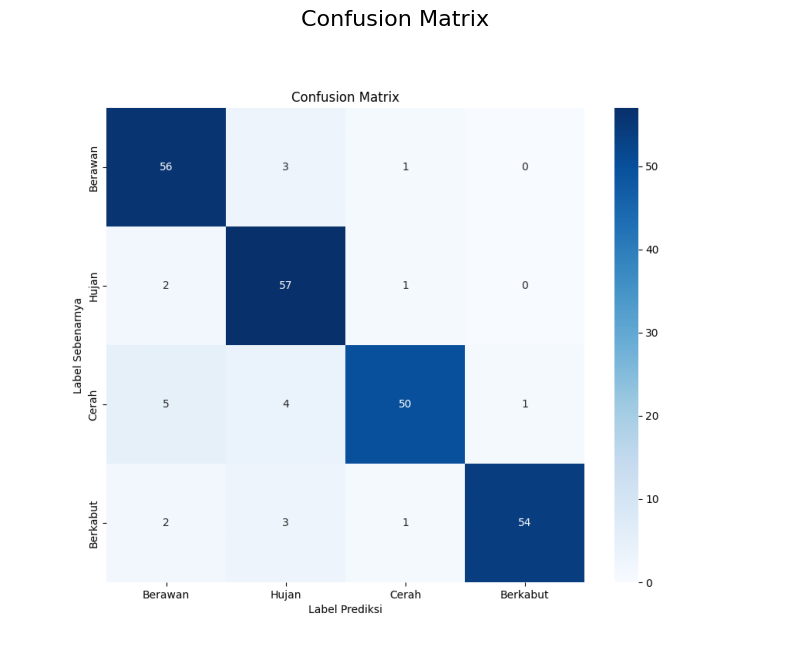

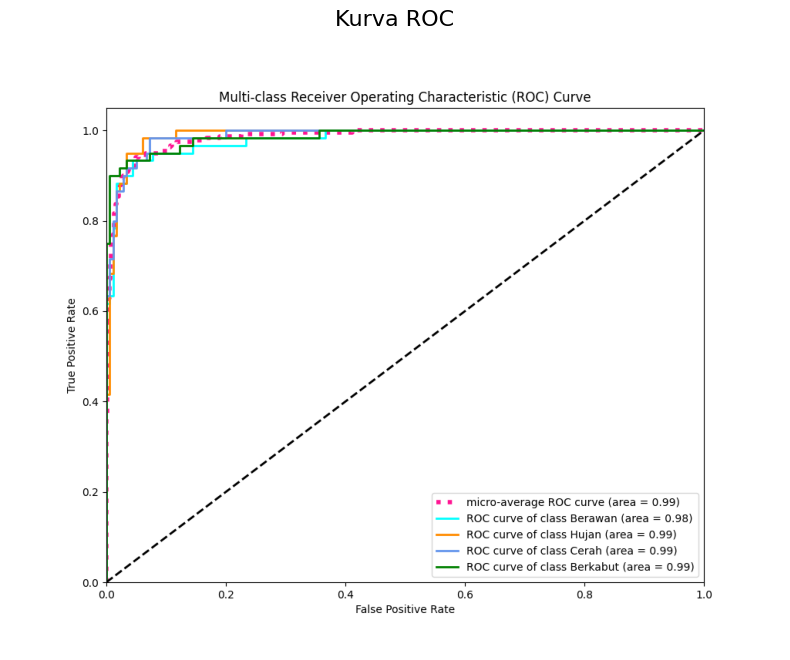

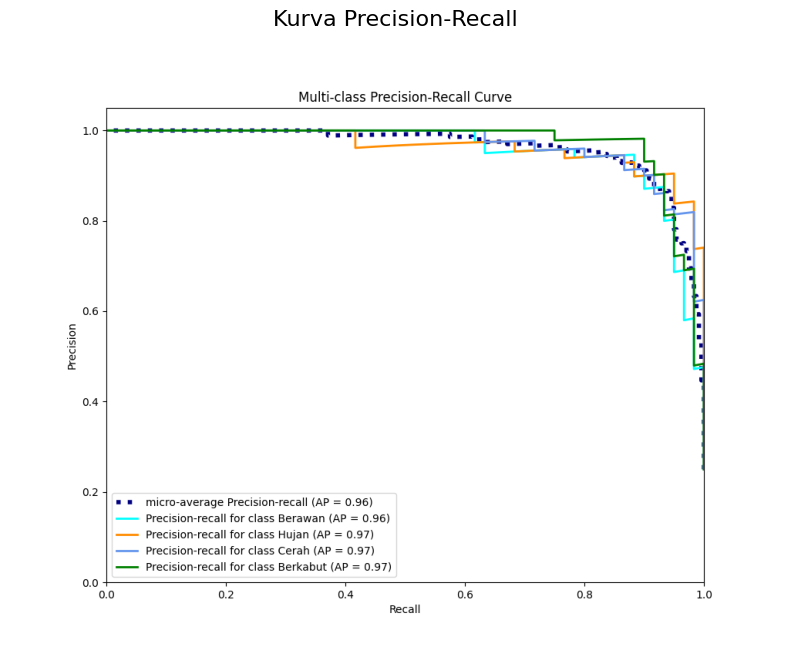

In [6]:
def display_image(path, title):
    """Membaca dan menampilkan file gambar dari path yang diberikan."""
    try:
        img = mpimg.imread(path)
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.title(title, fontsize=16)
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print(f"File tidak ditemukan di: {path}")

# Tampilkan visualisasi hasil evaluasi yang telah disimpan
display_image(os.path.join(RESULTS_PATH, 'confusion_matrix.png'), 'Confusion Matrix')
display_image(os.path.join(RESULTS_PATH, 'roc_curve.png'), 'Kurva ROC')
display_image(os.path.join(RESULTS_PATH, 'precision_recall_curve.png'), 'Kurva Precision-Recall')

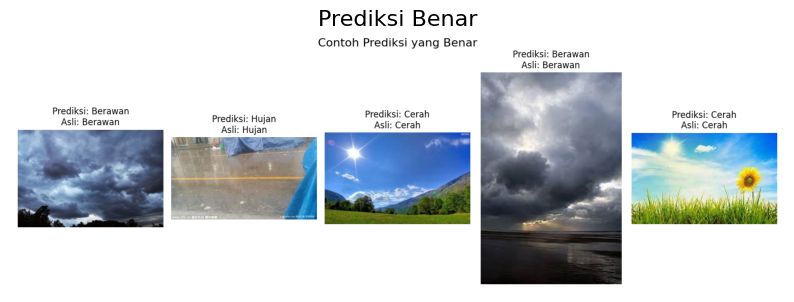

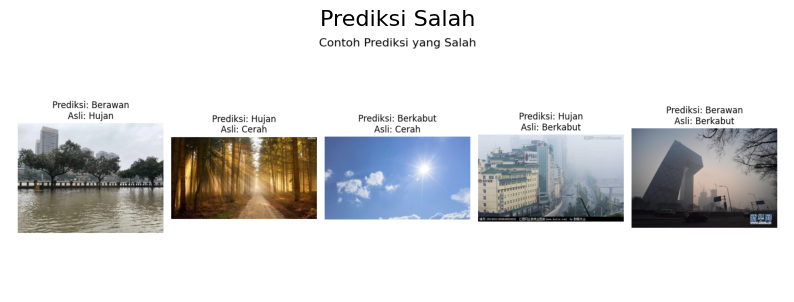

In [7]:
# Tampilkan contoh prediksi yang benar dan salah
display_image(os.path.join(RESULTS_PATH, 'correct_predictions.png'), 'Prediksi Benar')
display_image(os.path.join(RESULTS_PATH, 'incorrect_predictions.png'), 'Prediksi Salah')